# Import modules

In [1]:
""" Import modules """

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Define kernels

In [2]:
class Kernel(object):
    """
    Base class for kernel function
    """

    def _pairwise(self, x, y):
        """
        all pairs of x and y

        Parameters
        ----------
        x : (sample_size, n_features)
            input
        y : (sample_size, n_features)
            another input

        Returns
        -------
        output : tuple
            two array with shape (sample_size, sample_size, n_features)
        """
        return (
            np.tile(x, (len(y), 1, 1)).transpose(1, 0, 2),
            np.tile(y, (len(x), 1, 1))
        )

class PolynomialKernel(Kernel):
    """
    Polynomial kernel
    k(x,y) = (x @ y + c)^M
    """

    def __init__(self, degree=2, const=0.):
        """
        construct Polynomial kernel

        Parameters
        ----------
        const : float
            a constant to be added
        degree : int
            degree of polynomial order
        """
        self.const = const
        self.degree = degree

    def __call__(self, x, y, pairwise=True):
        """
        calculate pairwise polynomial kernel

        Parameters
        ----------
        x : (..., ndim) ndarray
            input
        y : (..., ndim) ndarray
            another input with the same shape

        Returns
        -------
        output : ndarray
            polynomial kernel
        """
        if pairwise:
            x, y = self._pairwise(x, y)
        return (np.sum(x * y, axis=-1) + self.const) ** self.degree


class RBF(Kernel):

    def __init__(self, params):
        """
        construct Radial basis kernel function

        Parameters
        ----------
        params : (ndim + 1,) ndarray
            parameters of radial basis function

        Attributes
        ----------
        ndim : int
            dimension of expected input data
        """
        assert params.ndim == 1
        self.params = params
        self.ndim = len(params) - 1

    def __call__(self, x, y, pairwise=True):
        """
        calculate radial basis function
        k(x, y) = c0 * exp(-0.5 * c1 * (x1 - y1) ** 2 ...)

        Parameters
        ----------
        x : ndarray [..., ndim]
            input of this kernel function
        y : ndarray [..., ndim]
            another input

        Returns
        -------
        output : ndarray
            output of this radial basis function
        """
        assert x.shape[-1] == self.ndim
        assert y.shape[-1] == self.ndim
        if pairwise:
            x, y = self._pairwise(x, y)
        d = self.params[1:] * (x - y) ** 2
        return self.params[0] * np.exp(-0.5 * np.sum(d, axis=-1))

    def derivatives(self, x, y, pairwise=True):
        if pairwise:
            x, y = self._pairwise(x, y)
        d = self.params[1:] * (x - y) ** 2
        delta = np.exp(-0.5 * np.sum(d, axis=-1))
        deltas = -0.5 * (x - y) ** 2 * (delta * self.params[0])[:, :, None]
        return np.concatenate((np.expand_dims(delta, 0), deltas.T))

    def update_parameters(self, updates):
        self.params += updates




# Define GP regressor

In [3]:
class GaussianProcessRegressor(object):

    def __init__(self, kernel, beta=1.):
        """
        construct gaussian process regressor

        Parameters
        ----------
        kernel
            kernel function
        beta : float
            precision parameter of observation noise
        """
        self.kernel = kernel
        self.beta = beta

    def fit(self, X, t, iter_max=0, learning_rate=0.1,learn_beta=False):
        """
        maximum likelihood estimation of parameters in kernel function

        Parameters
        ----------
        X : ndarray (sample_size, n_features)
            input
        t : ndarray (sample_size,)
            corresponding target
        iter_max : int
            maximum number of iterations updating hyperparameters
        learning_rate : float
            updation coefficient

        Attributes
        ----------
        covariance : ndarray (sample_size, sample_size)
            variance covariance matrix of gaussian process
        precision : ndarray (sample_size, sample_size)
            precision matrix of gaussian process

        Returns
        -------
        log_likelihood_list : list
            list of log likelihood value at each iteration
        """
        if X.ndim == 1:
            X = X[:, None]
        log_likelihood_list = [-np.Inf]
        self.X = X
        self.t = t
        I = np.eye(len(X))
        Gram = self.kernel(X, X)
        self.covariance = Gram + I / self.beta
        self.precision = np.linalg.inv(self.covariance)
        for i in range(iter_max):
            gradients = self.kernel.derivatives(X, X)
            updates = np.array(
                [-np.trace(self.precision.dot(grad)) + t.dot(self.precision.dot(grad).dot(self.precision).dot(t)) for grad in gradients])
            if learn_beta:
                beta_grad = -np.eye(X.shape[0]) / self.beta**2
                beta_upd = -np.trace(self.precision.dot(beta_grad)) + t.dot(self.precision.dot(beta_grad).dot(self.precision).dot(t))
            for j in range(iter_max):
                self.kernel.update_parameters(learning_rate * updates)
                if learn_beta:
                    self.beta += learning_rate *  beta_upd
                Gram = self.kernel(X, X)
                self.covariance = Gram + I / self.beta
                self.precision = np.linalg.inv(self.covariance)
                log_like = self.log_likelihood()
                if log_like > log_likelihood_list[-1]:
                    log_likelihood_list.append(log_like)
                    break
                else:
                    self.kernel.update_parameters(-learning_rate * updates)
                    if learn_beta:
                        self.beta -= learning_rate *  beta_upd
                    learning_rate *= 0.9
        log_likelihood_list.pop(0)
        return log_likelihood_list

    def log_likelihood(self):
        return -0.5 * (
            np.linalg.slogdet(self.covariance)[1]
            + self.t @ self.precision @ self.t
            + len(self.t) * np.log(2 * np.pi))

    def predict(self, X, with_error=False):
        """
        mean of the gaussian process

        Parameters
        ----------
        X : ndarray (sample_size, n_features)
            input

        Returns
        -------
        mean : ndarray (sample_size,)
            predictions of corresponding inputs
        """
        if X.ndim == 1:
            X = X[:, None]
        K = self.kernel(X, self.X)
        mean = K @ self.precision @ self.t
        if with_error:
            var = (
                self.kernel(X, X, False)
                + 1 / self.beta
                - np.sum(K @ self.precision * K, axis=1))
            return mean.ravel(), np.sqrt(var.ravel())
        return mean

# GP Regression

### Create toy data

In [4]:
""" create one period of the sine on [0,1] with added gaussian noise """

def create_toy_data(func, n=10, std=1., domain=[0., 1.]):
    x = np.linspace(domain[0], domain[1], n)
    t = func(x) + np.random.normal(scale=std, size=n)
    return x, t

def sinusoidal(x):
        return np.sin(2 * np.pi * x)

### GP fit

Here we fit a GP to the training data without learning the hyperparameters. First we use a polynomial kernel. Note that this means that the fitting curve is also a polynomial (this is especially important since the fitting curve will hence ALWAYS diverge to +$\infty$ or -$\infty$ away from the data).

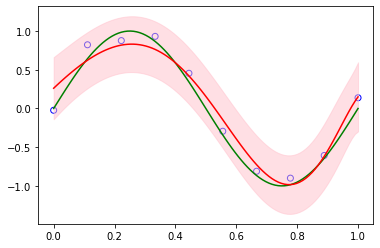

In [5]:
""" Get the predictive mean of a GP with PRESPECIFIED covariance(-hyperparameters) (and wrong noise estimate)"""

x_train, y_train = create_toy_data(sinusoidal, n=10, std=0.1)
x = np.linspace(0, 1, 100)
# x = np.linspace(-0.5, 1.5, 1000)

model = GaussianProcessRegressor(kernel=PolynomialKernel(12, 1.),beta=10.)
model.fit(x_train, y_train)

y, y_std = model.predict(x, with_error=True)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
plt.plot(x, y, color="r", label="gpr")
plt.fill_between(x, y - y_std, y + y_std, alpha=0.5, color="pink", label="std")
plt.show()

Next we use an RBF kernel. In contrast to the polynomil kernel, here the fitting curve will always revert back to the prior away from the data (which is constant $0$ in our case).

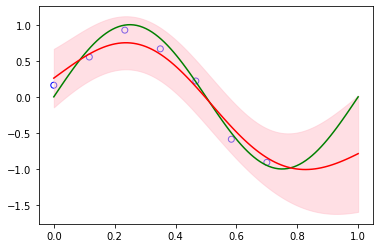

In [6]:
x_train, y_train = create_toy_data(sinusoidal, n=7, std=0.1, domain=[0., 0.7])
x = np.linspace(0, 1, 100)
# x = np.linspace(-2, 2, 1000)

model = GaussianProcessRegressor(kernel=RBF(np.array([1.,10.])),beta=10.)
model.fit(x_train, y_train)

y, y_std = model.predict(x, with_error=True)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
plt.plot(x, y, color="r", label="gpr")
# plt.xlim([-2,2])
plt.fill_between(x, y - y_std, y + y_std, alpha=0.5, color="pink", label="std")
plt.show()

### Learning the hyperparameters

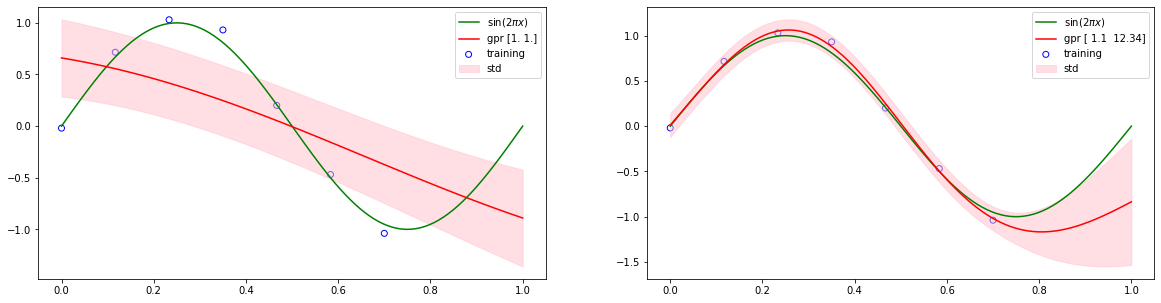

In [7]:
"""GP regression with real hyperparameter training"""
x_train, y_train = create_toy_data(sinusoidal, n=7, std=0.1, domain=[0., 0.7])
x = np.linspace(0, 1, 100)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model = GaussianProcessRegressor(kernel=RBF(np.array([1.,1.])),beta=10.)
model.fit(x_train, y_train)
y, y_std = model.predict(x, with_error=True)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
plt.plot(x, y, color="r", label="gpr {}".format(model.kernel.params))
plt.fill_between(x, y - y_std, y + y_std, alpha=0.5, color="pink", label="std")
plt.legend()

plt.subplot(1, 2, 2)
model.fit(x_train, y_train, iter_max=30000,learn_beta=True)
y, y_std = model.predict(x, with_error=True)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
plt.plot(x, y, color="r", label="gpr {}".format(np.round(model.kernel.params, 2)))
plt.fill_between(x, y - y_std, y + y_std, alpha=0.5, color="pink", label="std")
plt.legend()
plt.show()

### Automatic relevance determination

In [8]:
""" Create multidimensional data points, where the targets are only a function of the first component """
def create_toy_data_3d(func, n=10, std=1.):
    x0 = np.linspace(0, 1, n)
    x1 = x0 + np.random.normal(scale=std, size=n)
    x2 = np.random.normal(scale=std, size=n)
    t = func(x0) + np.random.normal(scale=std, size=n)
    return np.vstack((x0, x1, x2)).T, t

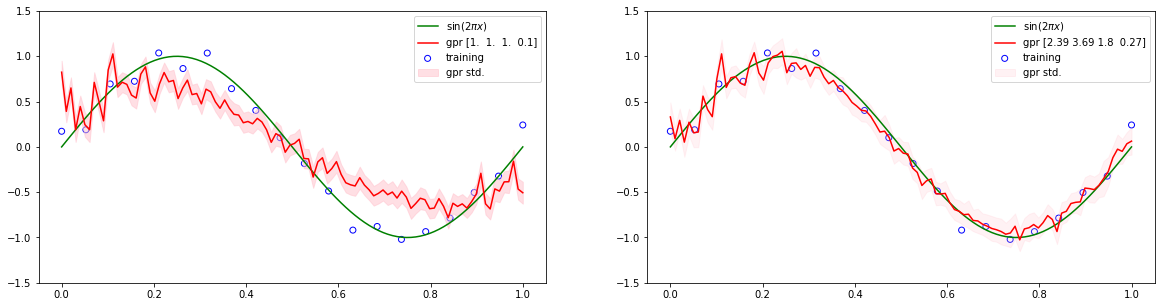

In [9]:
""" GP hyperparameter tuning with separate lengthscales for each input dimension. Note how the GP automatically determines the relevance of each input dimension. """
x_train, y_train = create_toy_data_3d(sinusoidal, n=20, std=0.1)
x0 = np.linspace(0, 1, 100)
x1 = x0 + np.random.normal(scale=0.1, size=100)
x2 = 1*np.random.normal(scale=0.1, size=100)
x = np.vstack((x0, x1, x2)).T

model = GaussianProcessRegressor(kernel=RBF(np.array([1., 1., 1., .1])), beta=100)
model.fit(x_train, y_train)
y, y_std = model.predict(x, with_error=True)
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], y_train, facecolor="none", edgecolor="b", label="training")
plt.plot(x[:, 0], sinusoidal(x[:, 0]), color="g", label="$\sin(2\pi x)$")
plt.plot(x[:, 0], y, color="r", label="gpr {}".format(model.kernel.params))
plt.fill_between(x[:, 0], y - y_std, y + y_std, color="pink", alpha=0.5, label="gpr std.")
plt.legend()
plt.ylim(-1.5, 1.5)

model.fit(x_train, y_train, iter_max=100, learning_rate=0.001)
y, y_std = model.predict(x, with_error=True)
plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], y_train, facecolor="none", edgecolor="b", label="training")
plt.plot(x[:, 0], sinusoidal(x[:, 0]), color="g", label="$\sin(2\pi x)$")
plt.plot(x[:, 0], y, color="r", label="gpr {}".format(np.round(model.kernel.params, 2)))
plt.fill_between(x[:, 0], y - y_std, y + y_std, color="pink", alpha=0.2, label="gpr std.")
plt.legend()
plt.ylim(-1.5, 1.5)
plt.show()